In [ ]:
# Hello World

In [1]:
import torch
import torchvision.transforms as T
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
from torch import tensor

In [ ]:
# You can downlaod the dataset using: kaggle competitions download -c imagenet-object-localization-challenge

# Utils

In [2]:
def display_image(img):
        with torch.no_grad():
                img = img.permute((1, 2, 0))
                plt.imshow(img.cpu().numpy())
                plt.show()

def display_images(imgs):
        with torch.no_grad():
                for i, img in enumerate(imgs):
                        plt.subplot(1, len(imgs), i+1)
                        img = img.permute((1, 2, 0))
                        plt.imshow(img.cpu().numpy())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataloading

In [3]:
IMAGE_SIZE = 200
train_tranforms = T.Compose([
    T.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

sanity_transforms = T.Compose([
    T.CenterCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# 1 is gold fish, 99  is goose 
# classes =  [1, 99]
# 980: volcano
classes =  [980]
# imagenet_dataset.class_to_idx

In [5]:
DATASET_PATH = '/pub2/imagenet/ILSVRC/Data/CLS-LOC/train'
imagenet_dataset = ImageFolder(root=DATASET_PATH, transform=sanity_transforms)
# sanity_imagenet_dataset = ImageFolder(root=DATASET_PATH, transform=sanity_transforms)

idx = [i for i in range(len(imagenet_dataset)) if imagenet_dataset.imgs[i][1] in classes]
train_subset = torch.utils.data.Subset(imagenet_dataset, idx)

sanity_subset = torch.utils.data.Subset(train_subset, [0])

In [6]:
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
sanity_loader = DataLoader(sanity_subset, batch_size=1, shuffle=True)

In [7]:
sample_batch = next(iter(sanity_loader))
sample_image = sample_batch[0][0]
sample_image = sample_image.float()
# sample_image = sample_image.unsqueeze(0)
print(sample_image.min(), sample_image.max())

tensor(0.) tensor(0.8745)


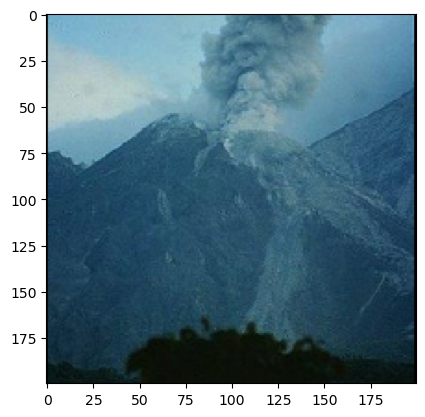

In [10]:
display_image(sample_image)
# for i in range(0, 10):
# 	display_image(sample_batch[0][i])
plt.show()

# Network

In [24]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')

        # self.conv_t1 = nn.ConvTranspose2d(256, 64, kernel_size=(2, 2), stride=(2, 2), padding=0, output_padding=0 )
        # self.conv_1 = nn.Conv2d(128, 90, kernel_size=5, padding=1)
        # self.batch_norm_1 = nn.BatchNorm2d(90)
        # self.conv_2 = nn.Conv2d(90, 128, kernel_size=5, padding=1)
        # self.batch_norm_2 = nn.BatchNorm2d(128)
        # self.conv_t2 = nn.ConvTranspose2d(128, 3, kernel_size=5, stride=4, padding=0, output_padding=0 )
        # self.conv_final = nn.Conv2d(3, 3, 1)
        # self.num_classes = 5

    def forward(self, inp):
        # Encoder
        original_inp = inp
        inp = self.resnet.conv1(inp)
        inp = self.resnet.bn1(inp)
        inp = self.resnet.relu(inp)
        skip = inp.clone()
        inp = self.resnet.maxpool(inp)
        inp = self.resnet.layer1(inp)
        inp = self.resnet.layer2(inp)
        inp = self.resnet.layer3(inp)
        inp = self.resnet.layer4(inp)

        print("fully encoded shape is", inp.shape)


        # Decoder
        # inp = self.conv_t1(inp)
        # diffY = inp.size()[2] - skip.size()[2]
        # diffX = inp.size()[3] - skip.size()[3]
        # skip = F.pad(skip, [diffX // 2, diffX - diffX // 2,
        #                 diffY // 2, diffY - diffY // 2])
        # inp = torch.concat([inp, skip], dim=1)
        # inp = self.conv_1(inp)
        # inp = self.batch_norm_1(inp)
        # inp = F.relu(inp)
        # inp = self.conv_2(inp)
        # inp = self.batch_norm_2(inp)
        # inp = F.relu(inp)
        # inp = self.conv_t2(inp)
        # inp = self.conv_final(inp)
        # new_shape = [original_inp.shape[2], original_inp.shape[3]]
        # inp = F.interpolate(inp, new_shape)
        # lfinal = inp

        return inp

In [12]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        embedding_dim = 2048
        # self.resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')

        self.conv_t1 = nn.ConvTranspose2d(embedding_dim, 1024, kernel_size=(2, 2), stride=(2, 2), padding=0, output_padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(1024)
        self.conv_t2 = nn.ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2), padding=0, output_padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(512)
        self.conv_t3 = nn.ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2), padding=0, output_padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(256)
        self.conv_t4 = nn.ConvTranspose2d(256, 64, kernel_size=(2, 2), stride=(2, 2), padding=0, output_padding=1)
        self.batch_norm_4 = nn.BatchNorm2d(64)
        self.conv_t5 = nn.ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2), padding=0, output_padding=1)
        self.batch_norm_5 = nn.BatchNorm2d(32)

        # nn.Upsample(scale_factor = 2, mode='bilinear'),
        #                   nn.ReflectionPad2d(1),
        #                   nn.Conv2d(ngf * mult, int(ngf * mult / 2),
        #                                      kernel_size=3, stride=1, padding=0)

        self.conv = nn.Conv2d(32, 3, kernel_size=4, stride=1, padding=1)


    def forward(self, inp):
        inp = self.conv_t1(inp)
        inp = self.batch_norm_1(inp)
        inp = F.relu(inp)

        inp = self.conv_t2(inp)
        inp = self.batch_norm_2(inp)
        inp = F.relu(inp)

        inp = self.conv_t3(inp)
        inp = self.batch_norm_3(inp)
        inp = F.relu(inp)

        inp = self.conv_t4(inp)
        inp = self.batch_norm_4(inp)
        inp = F.relu(inp)

        inp = self.conv_t5(inp)
        inp = self.batch_norm_5(inp)
        inp = F.relu(inp)

        inp = self.conv(inp)
        inp = torch.sigmoid(inp)
        # print("image size before decode is", inp.shape)
        inp = T.Resize((IMAGE_SIZE, IMAGE_SIZE))(inp)


        return inp

In [13]:

def try_running_image(img, encoder, decoder):
	img = img.to(device)
	img = img.unsqueeze(0)
	embedding = encoder(img)
	out = decoder(embedding)[0]
	return out.cpu()

# Train  

In [27]:
from tqdm import tqdm

encoder = Encoder()
encoder = encoder.to(device)
decoder = Decoder()
decoder = decoder.to(device)

In [15]:
optim = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.01)
loss_fn = nn.MSELoss()

fully encoded shape is torch.Size([1, 2048, 7, 7])


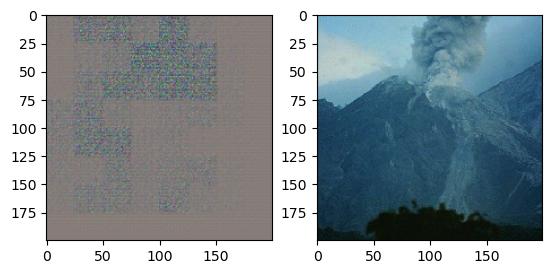

In [30]:
sample_untrained_out = try_running_image(sample_image, encoder, decoder)
display_images([sample_untrained_out, sample_image])

100%|██████████| 1/1 [00:00<00:00, 30.70it/s]


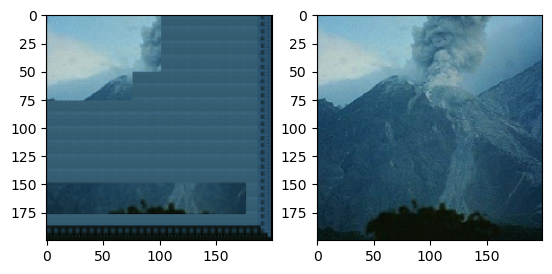

In [23]:
EPOCHS = 1000
for epcoh in range(EPOCHS):
	encoder.train()
	decoder.train()
	

	epoch_loss = 0
	total_number_of_images = len(sanity_loader)
	for index, batch in tqdm(enumerate(sanity_loader), total=total_number_of_images):
		data, _ = batch
		data = data.to(device)
		optim.zero_grad()

		embedded_images = encoder(data)
		decoded_images = decoder(embedded_images)

		loss = loss_fn(data, decoded_images)
		loss.backward()
		epoch_loss += loss.item()
		optim.step()
		display_images([decoded_images[0], data[0]])

	# print(f"Epoch Loss: {epoch_loss}")